<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Downloading model fields using netCDF Subset Service (NCSS)</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://unidata.github.io/siphon/latest/_static/siphon_150x150.png" alt="TDS" style="height: 200px;"></div>

## Overview:

* **Teaching:** 20 minutes
* **Exercises:** 20 minutes

### Questions
1. What is the netCDF Subset Service (NCSS)?
1. How can I use Siphon to make an NCSS request?
1. How do I plot gridded fields using CartoPy?

### Objectives
1. <a href="#ncss">Use siphon to make a request using NCSS</a>
1. <a href="#projection">Making sense of netCDF</a>
1. <a href="#plotting">Plot on a map</a>
1. <a href="#pointrequest">Requesting for a single point</a>

<a name="ncss"></a>
## 1. What is NCSS?

In [1]:
# Resolve the latest GFS dataset
import metpy
from siphon.catalog import TDSCatalog

# Set up access via NCSS
gfs_catalog = ('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
               'Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
cat = TDSCatalog(gfs_catalog)
ncss = cat.datasets[0].subset()

We can see what variables are available from ncss as well:

In [2]:
ncss.variables

{'5-Wave_Geopotential_Height_isobaric',
 'Absolute_vorticity_isobaric',
 'Albedo_surface_Mixed_intervals_Average',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Categorical_Freezing_Rain_surface',
 'Categorical_Freezing_Rain_surface_Mixed_intervals_Average',
 'Categorical_Ice_Pellets_surface',
 'Categorical_Ice_Pellets_surface_Mixed_intervals_Average',
 'Categorical_Rain_surface',
 'Categorical_Rain_surface_Mixed_intervals_Average',
 'Categorical_Snow_surface',
 'Categorical_Snow_surface_Mixed_intervals_Average',
 'Cloud_Work_Function_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Cloud_mixing_ratio_hybrid',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Composite_reflectivity_entire_atmosphere',
 'Convective_Precipitation_Rate_surface_Mixed_intervals_Average',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_p

From here, we can build a query to ask for the data we want from the server.

In [3]:
from datetime import datetime, timedelta

# Create a new NCSS query
query = ncss.query()

# Request data in netCDF format
query.accept('netcdf')

# Ask for our variable
query.variables('Temperature_isobaric')

# Ask for the 500 hPa surface
query.vertical_level(50000)

# Set the time range of data we want
now = datetime.utcnow()
query.time_range(now, now + timedelta(days=1))

# Set the spatial limits
query.lonlat_box(west=-110, east=-45, north=50, south=10)

# get the data!
data = ncss.get_data(query)

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="projection"></a>
## 2. Making sense of netCDF

In [4]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 2,1
    Type_of_generating_process: Forecast
    Analysis_or_forecast_generating_process_identifier_defined_by_originating_centre: Analysis from GFS (Global Forecast System)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /data/ldm/pub/native/grid/NCEP/GFS/Global_0p5deg/GFS-Global_0p5deg.ncx3; Translation Date = 2020-01-09T16:37:43.389Z
    geospatial_lat_min: 10.0
    geospatial_lat_max: 50.0
    geospatial_lon_min: -110.0
    geospatial_lon_max: -45.0
    dimensions(sizes): time(8), isobaric6(1), lat(81), lon(131)
    variables(dimensions): float32 Temperatur

We can use a library called XArray to make working with this a little simpler

In [5]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

# We need the datastore so that we can open the existing netcdf dataset we downloaded
ds = xr.open_dataset(NetCDF4DataStore(data))

In [6]:
var = ds.metpy.parse_cf('Temperature_isobaric')
var

<xarray.DataArray 'Temperature_isobaric' (time: 8, isobaric6: 1, lat: 81, lon: 131)>
array([[[[241.21298, ..., 241.61299],
         ...,
         [269.413  , ..., 266.61298]]],


       ...,


       [[[242.68405, ..., 233.68405],
         ...,
         [268.18405, ..., 265.48407]]]], dtype=float32)
Coordinates:
    reftime    (time) datetime64[ns] ...
  * time       (time) datetime64[ns] 2020-01-09T18:00:00 ... 2020-01-10T15:00:00
  * isobaric6  (isobaric6) float32 50000.0
  * lat        (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 11.5 11.0 10.5 10.0
  * lon        (lon) float32 250.0 250.5 251.0 251.5 ... 313.5 314.0 314.5 315.0
    crs        object Projection: latitude_longitude
Attributes:
    long_name:                      Temperature @ Isobaric surface
    units:                          K
    abbreviation:                   TMP
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-0-0_L100
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Temperature
    Grib2_Parameter_Name:           Temperature
    Grib2_Level_Type:               100
    Grib2_Level_Desc:               Isobaric surface
    Grib2_Generating_Process_Type:  Forecast

XArray handles parsing things like dates, times, latitude, and longitude for us

In [7]:
latitude = var.metpy.y
longitude = var.metpy.x

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="plotting"></a>
## Visualize the grid

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


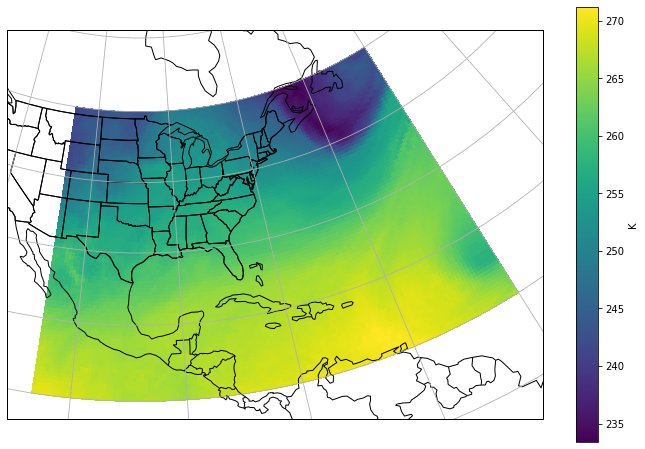

In [8]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# GFS uses lon/lat grid
data_projection = ccrs.PlateCarree()

# Make it easy to change what time step we look at
t_step = 0

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
mesh = ax.pcolormesh(longitude, latitude, var[t_step].squeeze(),
                     transform=data_projection, zorder=0)

# add some common geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

# add some lat/lon gridlines
ax.gridlines()

# add a colorbar
cax = fig.colorbar(mesh)
cax.set_label(var.attrs['units'])

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
        <li>Extend the plot above by plotting contours of 500 hPa geopotential heights</li>
        <li>Add a title to the plot with the correct time</li>
    </ul>
</div>

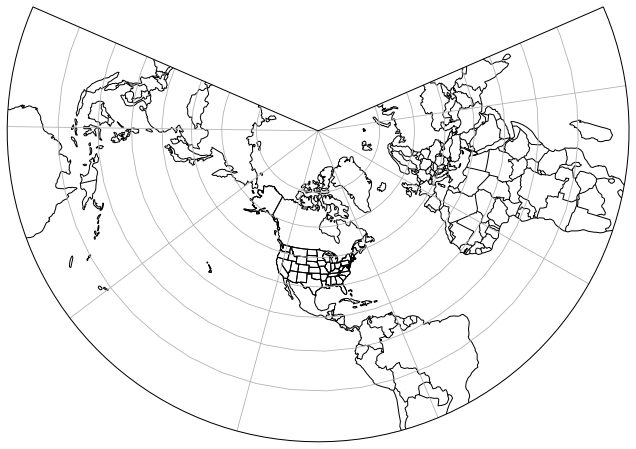

In [9]:
# Set up an NCSS query from thredds using siphon
query = ncss.query()

#
# SET UP QUERY
#

# Download data using NCSS
#ncss.get_data(query)

data_projection = ccrs.PlateCarree()

# Plot using CartoPy and Matplotlib
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())

#
# YOUR PLOT HERE
#

# add some common geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

# add some lat/lon gridlines
ax.gridlines()

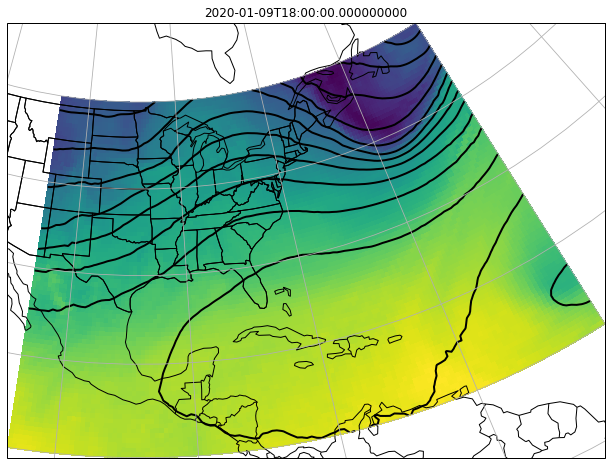

In [10]:
# %load solutions/map.py

# Cell content replaced by load magic replacement.
import numpy as np

# Set up an NCSS query from thredds using siphon
query = ncss.query()
query.accept('netcdf4')
query.variables('Temperature_isobaric', 'Geopotential_height_isobaric')
query.vertical_level(50000)
now = datetime.utcnow()
query.time_range(now, now + timedelta(days=1))
query.lonlat_box(west=-110, east=-45, north=50, south=10)

# Download data using NCSS
data = ncss.get_data(query)
ds = xr.open_dataset(NetCDF4DataStore(data))

temp_var = ds.metpy.parse_cf('Temperature_isobaric')
height_var = ds.metpy.parse_cf('Geopotential_height_isobaric')
longitude = temp_var.metpy.x
latitude = temp_var.metpy.y
time_index = 0

# Plot using CartoPy and Matplotlib
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())

contours = np.arange(5000, 6000, 80)
ax.pcolormesh(longitude, latitude, temp_var[time_index].squeeze(),
              transform=data_projection, zorder=0)
ax.contour(longitude, latitude, height_var[time_index].squeeze(), contours, colors='k',
           transform=data_projection, linewidths=2, zorder=1)
ax.set_title(temp_var.metpy.time[time_index].values)

# add some common geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

# add some lat/lon gridlines
ax.gridlines()

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="pointrequest"></a>
## 4. NCSS Point Request
We can also request data for a specfic lon/lat point, across vertical coordinates or times.

In [11]:
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                 'Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
ncss = cat.datasets[0].subset()

point_query = ncss.query()
point_query.time(datetime.utcnow())
point_query.accept('netcdf4')
point_query.variables('Temperature_isobaric', 'Relative_humidity_isobaric')
point_query.variables('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
point_query.lonlat_point(-101.877, 33.583)

# get the data! Unfortunately, xarray does not quite like what comes out of thredds
point_data = ncss.get_data(point_query)

Skew-T diagrams typical use specific units. First, let's assign units to the variables we requested:

In [12]:
from metpy.units import units
import numpy as np

# get netCDF variables
pressure = point_data.variables["isobaric"]
dname_temp = point_data.variables["Temperature_isobaric"].dimensions[2]
lev_temp = point_data.variables[dname_temp]
temp = point_data.variables["Temperature_isobaric"]
u_cmp = point_data.variables["u-component_of_wind_isobaric"]
v_cmp = point_data.variables["v-component_of_wind_isobaric"]
relh = point_data.variables["Relative_humidity_isobaric"]

# download data and assign the units based on the variables metadata
# Need to put units on the left to assure things work properly with masked arrays
p = units(pressure.units) * pressure[:].squeeze()
T = units(temp.units) * temp[:].squeeze()
u = units(u_cmp.units) * u_cmp[:].squeeze()
v = units(v_cmp.units) * v_cmp[:].squeeze()
relh = units('percent') * relh[:].squeeze()

# Due to a different number of vertical levels find where they are common
_, _, common_ind = np.intersect1d(pressure, lev_temp, return_indices=True)
T = T[common_ind]

We also need to calculate dewpoint from our relative humidity data:

In [13]:
import metpy.calc as mpcalc

Td = mpcalc.dewpoint_rh(T, relh)

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/metpy/xarray.py:655: MetpyDeprecationWarning: The dewpoint_rh function was deprecated in version 0.12. This function has been renamed dewpoint_from_relative_humidity.
  return func(*args, **kwargs)
/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: divide by zero encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)


Now, let's change those units to what we typically see used in Skew-T diagrams. We use `ito` to do this in-place rather than manually reassigning to the same variable.

In [14]:
p.ito(units.millibar)
T.ito(units.degC)
Td.ito(units.degC)
u.ito(units.knot)
v.ito(units.knot)

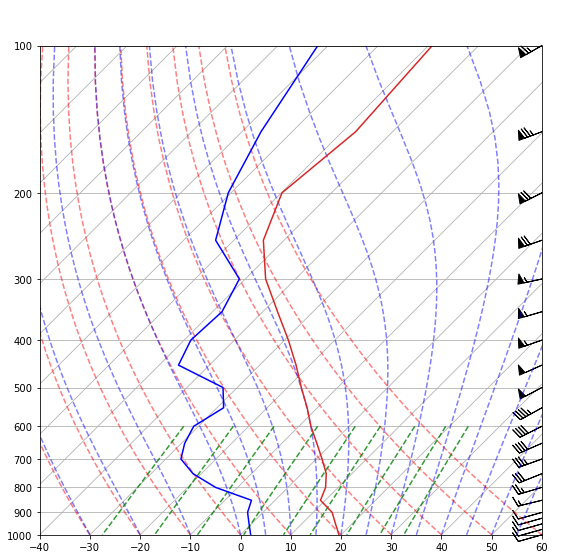

In [15]:
from metpy.plots import SkewT

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'tab:red')
skew.plot(p, Td, 'blue')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()